#### <h1 style="text-align:center">Data Science and Machine Learning Capstone Project</h1>
<img style="float:right" src="https://prod-edxapp.edx-cdn.org/static/edx.org/images/logo.790c9a5340cb.png">
<p style="text-align:center">IBM: DS0720EN</p>
<p style="text-align:center">Question 4 of 4</p>

1. [Frame the Problem](#frame)
2. [Collect Data](#collect)
3. [Process Data](#process)
4. [Explore the Data](#explore)
5. [Interpret](#interpret)
6. [Concluding Remarks](#conclusion)

<a id="frame"></a>
# Frame the Problem
---
Ask the right questions.

## Problem Statement

The people of New York use the 311 system to report complaints about the non-emergency problems to local authorities. Various agencies in New York are assigned these problems. The Department of Housing Preservation and Development of New York City is the agency that processes 311 complaints that are related to housing and buildings.

In the last few years, the number of 311 complaints coming to the Department of Housing Preservation and Development has increased significantly. Although these complaints are not necessarily urgent, the large volume of complaints and the sudden increase is impacting the overall efficiency of operations of the agency.

Therefore, the Department of Housing Preservation and Development has approached your organization to help them manage the large volume of 311 complaints they are receiving every year.

The agency needs answers to several questions. The answers to those questions must be supported by data and analytics. These are their  questions:

## Question 4

Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?

## Approach
Attempt to build a predictive model to predict heating complaints by using past data.
Assemble complaint data vs. time.
Graph it to get a sense of any patterns.
Build model.
Test model 

Determine relationship between number of complaints over time.
Establish regression model to calculate number of complaints for each day of the year.

Because the building data itself doesn't change over time, I will be looking for patterns in the number of complaints based only on time of year.  My hunch is that there will be more heating complaints in the winter.

<a id="collect"></a>
# Collect Data
Separately from this notebook:

The [New York 311](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9) data was loaded by [SODA](https://data.cityofnewyork.us/resource/fhrw-4uyv.csv?$limit=100000000&Agency=HPD&$select=created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status) into a Pandas DataFrame then saved to a pickle file.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

files_path = 'C:\\Users\\It_Co\\Documents\\DataScience\\Capstone\\' #local
#files_path = './' #IBM Cloud / Watson Studio

In [2]:
# Only load the NY 311 data for this question.
df = pd.read_pickle(files_path + 'ny311full.pkl')
print("Shape of initial data %s" % (df.shape,))

Shape of initial data (5862383, 15)


<a id="process"></a>
# Process Data
---
Wrangling, standardization, feature engineering

In [3]:
# Remove features deemed unnecessary for this question.
df.drop(['street_name','address_type','resolution_description','closed_date','location_type','status','unique_key','latitude','longitude','incident_zip','incident_address','city','borough'], axis=1, inplace=True)
print("Shape after first feature culling %s" % (df.shape,))

Shape after first feature culling (5862383, 2)


In [4]:
# Only use the combined "heating and hot water" type of observations determined from Question 1.
df['complaint_type'] = df['complaint_type'].str.upper()
df.drop(df[df["complaint_type"].isin(["HEAT/HOT WATER","HEATING"])==False].index, axis=0, inplace=True)
# The complaint type is only used for filtering observations this time.
df.drop(['complaint_type'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
print("Shape after row culling based on complaint type %s" % (df.shape,))

Shape after row culling based on complaint type (2040461, 1)


In [5]:
# Data types
df.dtypes

created_date    object
dtype: object

In [6]:
# Convert the date into actual datetime type.
df['created_date'] = pd.to_datetime(df['created_date'])
df.dtypes

created_date    datetime64[ns]
dtype: object

In [7]:
# Nulls
df.isnull().sum()

created_date    0
dtype: int64

In [8]:
# Check ranges
df.describe()

,created_date
count,2040461
unique,855540
top,2013-01-24 00:00:00
freq,5847
first,2010-01-01 00:00:00
last,2019-09-28 23:48:12


## Latent variables
Derived from the other data

### Break the created_date into latent variables for year and day of year.

In [9]:
# Break the created_date into latent variables for year and day of year.
df['Year'] = df['created_date'].dt.year
df['DayOfYear'] = df['created_date'].dt.dayofyear

### Structure the data into total complaints per day.

In [10]:
totals = df.groupby(['Year','DayOfYear']).size()
totals = pd.DataFrame(totals)
totals.reset_index(inplace=True)
totals.columns=['Year','DayOfYear','Complaints']
totals.head()

,Year,DayOfYear,Complaints
0,2010,1,770
1,2010,2,1457
2,2010,3,2785
3,2010,4,2740
4,2010,5,2036


<a id="explore"></a>
# Explore the Data
---
Visualization

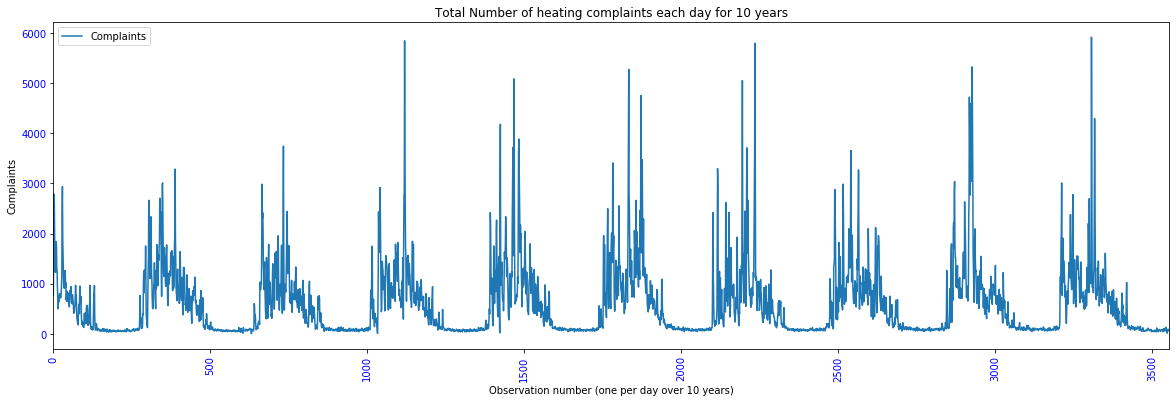

In [11]:
# Basic visualization
totals[['Complaints']].plot(title="Total Number of heating complaints each day for 10 years", figsize=(20,6))
plt.xticks(rotation=90,color='blue')
plt.yticks(color='blue')
plt.ylabel("Complaints")
plt.xlabel("Observation number (one per day over 10 years)")
plt.show()

<p style="color:Red;"><b>Observation:</b>  There appears to be a general recurring U pattern each year.  Presumably there are more heating complaints in the winter months when it is colder.</p>

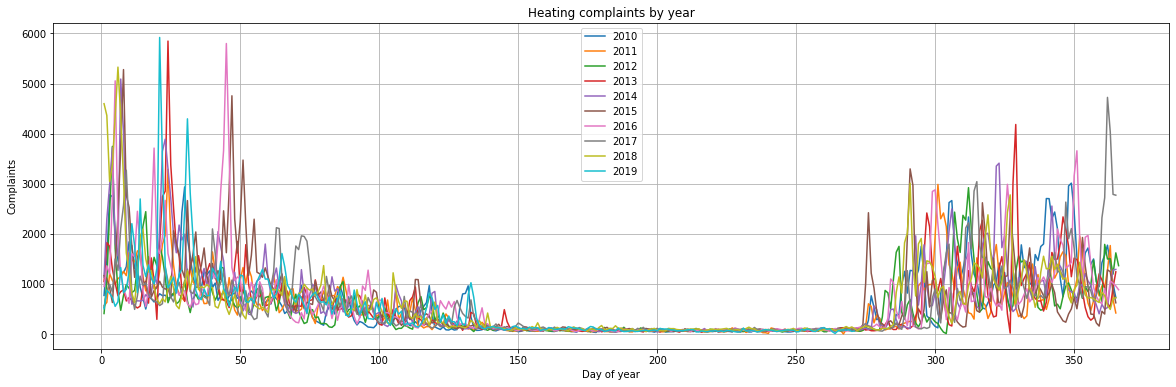

In [12]:
# Visualize how much it changes year to year.
plt.figure(figsize=(20,6))
plt.title("Heating complaints by year")
for yr in range(2010,2020,1):
    plt.plot(totals[totals['Year'].eq(yr)][['DayOfYear']], totals[totals['Year'].eq(yr)][['Complaints']], label=str(yr))
plt.legend()
plt.xlabel('Day of year')
plt.ylabel('Complaints')
plt.grid()
plt.show()

<p style="color:Red;"><b>Observation:</b>  There is a lot of variance in the number of complaints during the winter.  But each year generally follows the same basic pattern.</p>

<a id="analysis"></a>
# Analysis
---
Use Machine learning, statistical models, and algorithms to gain insights and predictions.

### Simple Linear Regression
A long shot given the curved shape of the results above, but try it anyway to confirm.

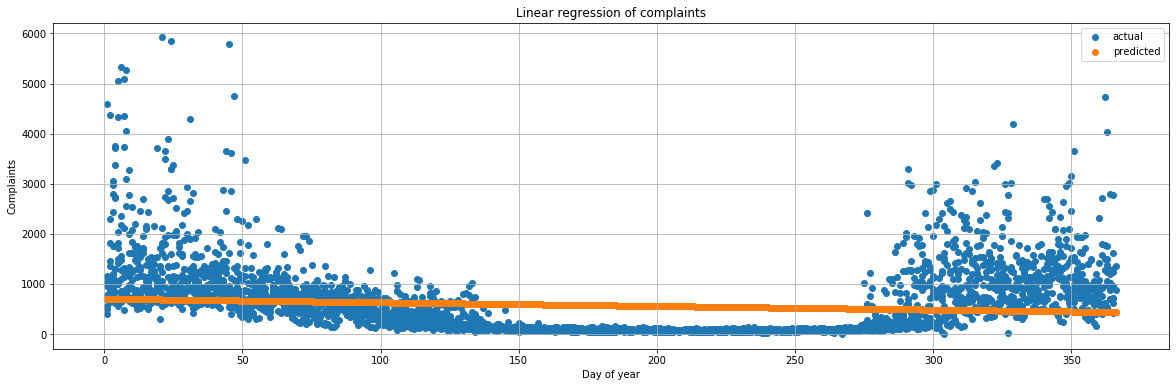

In [13]:
lm=LinearRegression()
X = totals[['DayOfYear']]
Y = totals[['Complaints']]
lm.fit(X,Y)
Yhat=lm.predict(X)
plt.figure(figsize=(20,6))
plt.title("Linear regression of complaints")
plt.scatter(X, Y, label="actual")
plt.scatter(X, Yhat, label="predicted")
plt.legend()
plt.xlabel('Day of year')
plt.ylabel('Complaints')
plt.grid()
plt.show()

<p style="color:Red;">As expected, a simple linear model does not fit the data well.  The parabolic U shape of the data suggests a Non-Linear quadratic function.</p>

### Poisson Regression
Supposedly more suitable for predicting "count" based values.

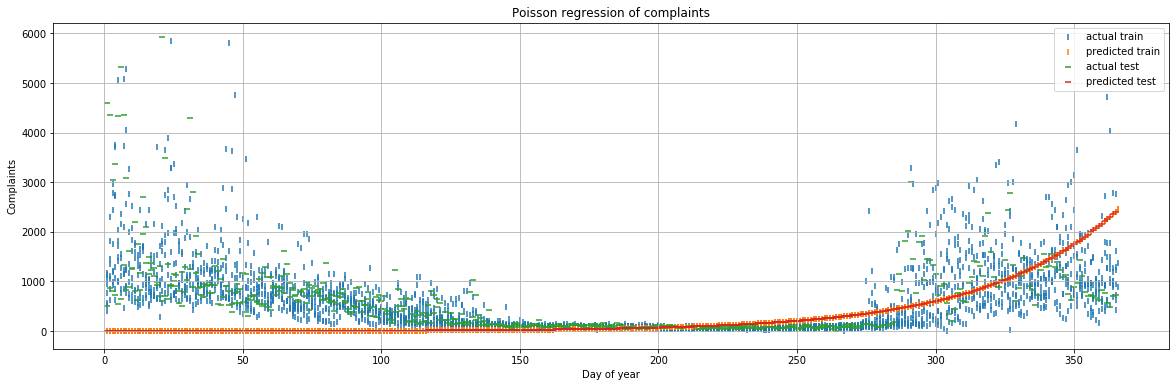

Train
  Mean squared error:  590449.7407013891
  R-squared:  -0.26911688129883005
Test
  Mean squared error:  715958.7446888726
  R-squared:  -0.42203226459554033


In [14]:
# Poisson regression
Xtrain = totals[totals['Year'].lt(2018)][['DayOfYear']]
Ytrain = totals[totals['Year'].lt(2018)][['Complaints']]
Xtest = totals[totals['Year'].ge(2018)][['DayOfYear']]
Ytest = totals[totals['Year'].ge(2018)][['Complaints']]

poisson_model = sm.GLM(Ytrain, Xtrain, family=sm.families.Poisson())
fitted_model = poisson_model.fit()

poisson_predictions = fitted_model.get_prediction(Xtrain)
predictions_summary_frame = poisson_predictions.summary_frame() #.summary_frame() returns a pandas DataFrame
Y_hat_train = predictions_summary_frame['mean']

poisson_predictions = fitted_model.get_prediction(Xtest)
predictions_summary_frame = poisson_predictions.summary_frame()
Y_hat_test = predictions_summary_frame['mean']

plt.figure(figsize=(20,6))
plt.title("Poisson regression of complaints")
plt.scatter(Xtrain, Ytrain, label="actual train", marker ='|')
plt.scatter(Xtrain, Y_hat_train, label="predicted train", marker ='|')
plt.scatter(Xtest, Ytest, label="actual test", marker ='_')
plt.scatter(Xtest, Y_hat_test, label="predicted test", marker ='_')
plt.legend()
plt.xlabel('Day of year')
plt.ylabel('Complaints')
plt.grid()
plt.show()
print('Train')
print('  Mean squared error: ', mean_squared_error(Ytrain, Y_hat_train))
print('  R-squared: ', r2_score(Ytrain, Y_hat_train))
print('Test')
print('  Mean squared error: ', mean_squared_error(Ytest, Y_hat_test))
print('  R-squared: ', r2_score(Ytest, Y_hat_test))    

<p style="color:Red;">Poisson did not work well at all.  It seems to be trying to approach the average on the day with the highest average.  Perhaps it isn't suitable because we have only one feature (day of year) that is going in, so it can't model a parabolic shape?  Perhaps having the continuous number of each time interval itself as the only feature is the problem?  From my research, Poisson doesn't work very well if the variation of the data doesn't match the mean.</p>

In [15]:
print(totals['Complaints'].var())
print(totals['Complaints'].mean())

472260.7937598781
573.8079302587176


<p style="color:Red;">The variance isn't close to the mean at all.  Research suggests Negative Binomial Regression and some other types of regression could possibly work better for count data when the variance and mean differ.  Because count data often has a mean pressed down around zero.  However, only two days out the ten years had zero heating complaints.  As such, this "count" value may be able to work similarly to a "continuous" value.  For the time being, I will try the Polynomial Regression covered in the course material.</p>

### Polynomial Regression
The Non-Linear quadratic function for a parabolic shape is a degree two polynomial.  ax^2 + bx + c = 0.  So perhaps this will model the situation better.

In [16]:
# Function for visualizing and/or measuring different degree polynomials.
def poly(degrees, mode):
    # training data is years 2010-2017.  Test data is 2018 to present.
    Xtrain = totals[totals['Year'].lt(2018)][['DayOfYear']]
    Ytrain = totals[totals['Year'].lt(2018)][['Complaints']]
    Xtest = totals[totals['Year'].ge(2018)][['DayOfYear']]
    Ytest = totals[totals['Year'].ge(2018)][['Complaints']]
    lr = LinearRegression()
    Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=degrees, include_bias=False)), ('model',lr)]
    pipe=Pipeline(Input)
    pipe.fit(Xtrain,Ytrain)
    Y_hat_train =pipe.predict(Xtrain)
    Y_hat_test =pipe.predict(Xtest)
    train_r = r2_score(Ytrain, Y_hat_train)
    test_r = r2_score(Ytest, Y_hat_test)    
    if mode=="VISUALIZE":
        plt.figure(figsize=(20,6))
        plt.title("Polynomial (degree " + str(degrees) + ") regression of heating complaints")
        plt.scatter(Xtrain, Ytrain, label="actual train", marker ='|')
        plt.scatter(Xtrain, Y_hat_train, label="predicted train", marker ='|')
        plt.scatter(Xtest, Ytest, label="actual test", marker ='_')
        plt.scatter(Xtest, Y_hat_test, label="predicted test", marker ='_')
        plt.legend()
        plt.xlabel('Day of year')
        plt.ylabel('Complaints')
        plt.grid()
        plt.show()
        print('Train')
        print('  Mean squared error: ', mean_squared_error(Ytrain, Y_hat_train))
        print('  R-squared: ', train_r)
        print('Test')
        print('  Mean squared error: ', mean_squared_error(Ytest, Y_hat_test))
        print('  R-squared: ', test_r)
        return
    if mode=="EQUATION":
        print(lr.coef_)
    return train_r, test_r

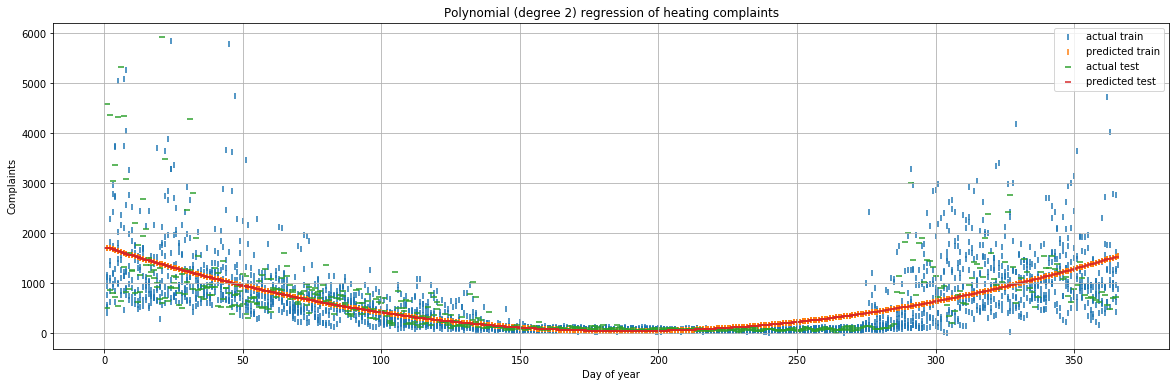

Train
  Mean squared error:  239448.3635704648
  R-squared:  0.4853279805904034
Test
  Mean squared error:  256707.44887881295
  R-squared:  0.4901294556765041


In [17]:
poly(2, "VISUALIZE")

<p style="color:Red;">Better but not a very good match between about 250 and 275 especially.</p>

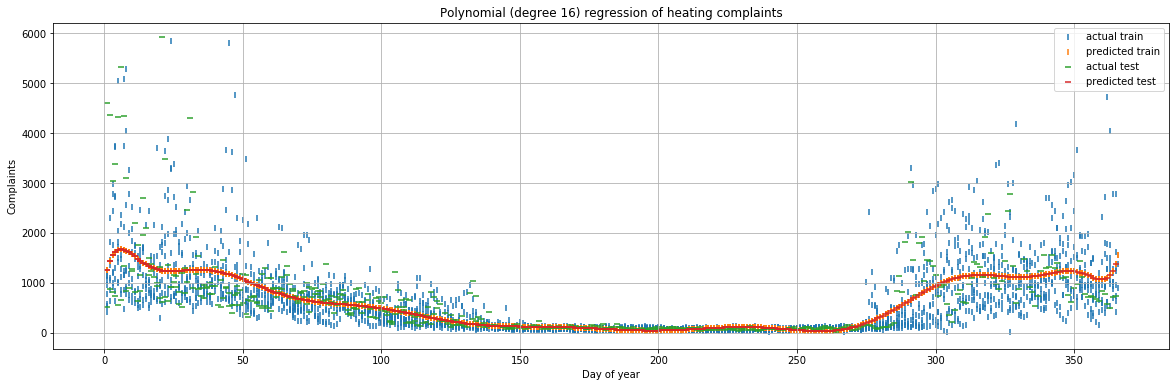

Train
  Mean squared error:  219381.39703654932
  R-squared:  0.5284600614926634
Test
  Mean squared error:  245486.26626481695
  R-squared:  0.512416890312078


In [18]:
poly(16, "VISUALIZE")

<p style="color:Red;">An even higher degree polynomial seems to better match, with a lower error rate.  The percentage the model matches the data (R-Squared) has improved.  But will need to take a closer look to determine whether this is overfitted.</p>

### Polynomial Regression optimization
Determine the best performing degree before it over fits.

In [19]:
# Run through a series of degrees and measure the training and testing accuracy of each to detect where it overfits
measurements = pd.DataFrame(columns=['Degree', 'Train', 'Test'])
which_degree = 0
max = 0.0
for d in range(1,31,1):
    train, test = poly(d, "measure")
    if test > max:
        max = test
        which_degree = d
    measurements = measurements.append({'Degree':d, 'Train':train, 'Test':test}, ignore_index=True)
    #print("%i %.4f, %.4f" % (d, train, test))
measurements.head()

,Degree,Train,Test
0,1.0,0.006045,0.031207
1,2.0,0.485328,0.490129
2,3.0,0.485443,0.488635
3,4.0,0.493405,0.484839
4,5.0,0.500957,0.513099


In [20]:
print("Highest accuracy on test data %.4f the degree was %i." % (max, which_degree))

Highest accuracy on test data 0.5187 the degree was 11.


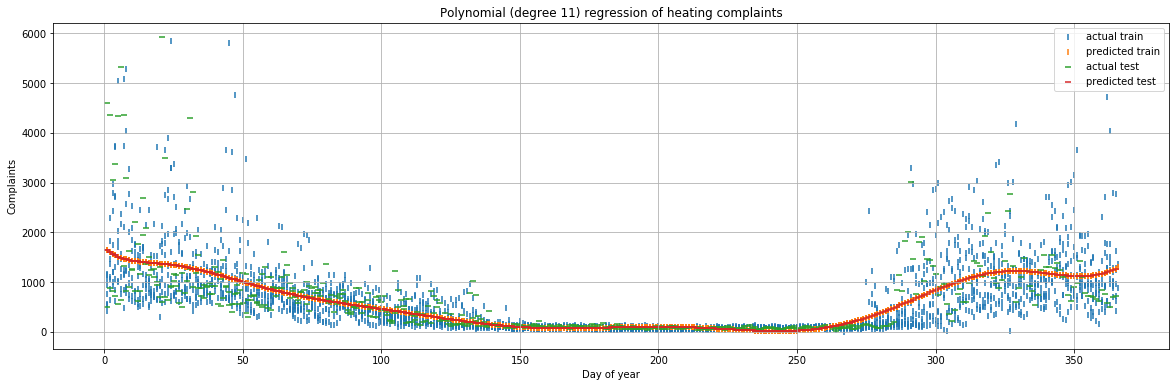

Train
  Mean squared error:  223445.1945028813
  R-squared:  0.519725306252404
Test
  Mean squared error:  242328.48194739697
  R-squared:  0.5186888594964987


In [21]:
# Visualize the most optimal polynomial found.
poly(11, "VISUALIZE")

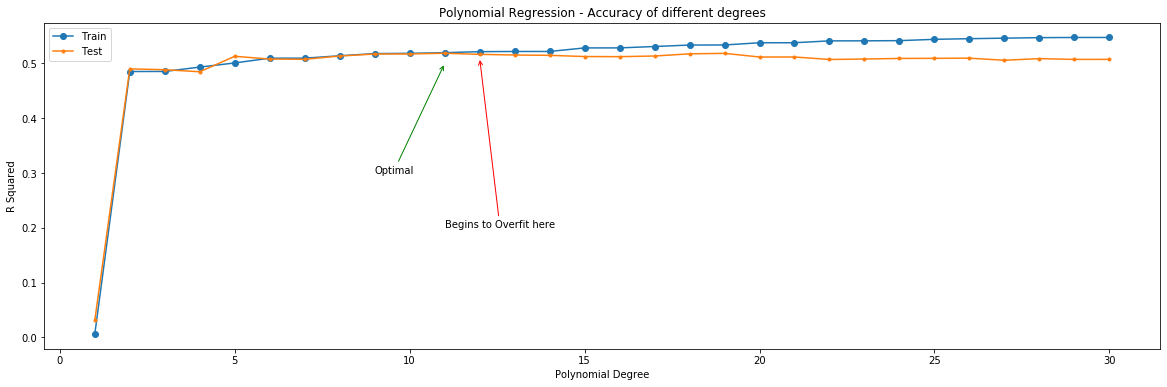

In [22]:
plt.figure(figsize=(20,6))
plt.title("Polynomial Regression - Accuracy of different degrees")
plt.plot(measurements['Degree'], measurements['Train'], label="Train", marker ='o')
plt.plot(measurements['Degree'], measurements['Test'], label="Test", marker ='.')
plt.legend()
plt.xlabel('Polynomial Degree')
plt.ylabel('R Squared')
plt.annotate("Begins to Overfit here", xy = (12,0.51), xycoords='data', xytext=(11,0.20), arrowprops=dict(arrowstyle= '->', color='red'))
plt.annotate("Optimal", xy = (11,0.50), xycoords='data', xytext=(9,0.30), arrowprops=dict(arrowstyle= '->', color='green'))

plt.show()

<p style="color:Red;">The most accurate polynomial regression model appears to be 11 degrees, with the following coefficients:</p>

In [23]:
__,__ = poly(11,"EQUATION")

[[  148.63568497   -41.19777465 -2198.47231778   618.70232274
   4109.98923367   146.68044912 -2859.89238577  -255.97026505
    852.09892161    52.34765592   -92.40624773]]


<a id="interpret"></a>
# Interpret
---
Make use of the analysis models to predict a future result

In [24]:
# Create a function for predicting a number of complaints for a given date based on the model trained with historic data.
def predict_heating_complaints(date):
    parsed = pd.to_datetime(date)
    day = parsed.dayofyear
    degrees = 11
    Xtrain = totals[['DayOfYear']]
    Ytrain = totals[['Complaints']]
    Xtest = pd.DataFrame(data={"DayOfYear":day},index=[0])
    lr = LinearRegression()
    Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=degrees, include_bias=False)), ('model',lr)]
    pipe=Pipeline(Input)
    pipe.fit(Xtrain,Ytrain)
    Y_hat_test =pipe.predict(Xtest)
    return "Predicted number of heating complaints for {} is {}.".format(date,int(Y_hat_test[0]))

In [25]:
# Predict the future
print(predict_heating_complaints("2020-01-01")) # New years day
print(predict_heating_complaints("2020-07-04")) # Independence day
print(predict_heating_complaints("2020-12-25")) # Christmas

Predicted number of heating complaints for 2020-01-01 is 1834.
Predicted number of heating complaints for 2020-07-04 is 93.
Predicted number of heating complaints for 2020-12-25 is 1120.


<a id="conclusion"></a>
# Concluding Remarks
---

Yes, a predictive model can be built for future prediction of complaints of the HEATING type identified in response to question one.

I was able to create a polynomial regression model to predict the number of complaints for any given day.

However, the historical number of complaints on a given day has a high variance, and the model only explains about 50% of this variance based on the R-Squared value.  Other types of models should also be explored.  Also, the main consideration affecting the prediction is time, so it seems to be weather related.  A more sophisticated model that includes weather forecasting data should also be considered.